In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
import numpy.linalg as npl
from scipy.integrate import solve_ivp

# --- 1. CONFIGURATION ---
FIT_PARAMS_FILE = "mw_fit_out_guild_hard_targets/fitted_global_params.csv"
OUTPUT_DIR = "full_analysis_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_HILL = 3
KQ = 80

# --- 2. LOAD FITTED PARAMETERS ---
try:
    g = pd.read_csv(FIT_PARAMS_FILE, index_col=0, header=None).squeeze("columns")
    print(f"✅ Successfully loaded parameters from {FIT_PARAMS_FILE}")
except FileNotFoundError:
    print(f"❌ Error: Parameter file not found at {FIT_PARAMS_FILE}")
    print("Please make sure you have run your fitting script (3.txt) first.")
    exit()

PARAM_NAMES = list(g.index.values)
p_fit = np.array([float(g[k]) for k in PARAM_NAMES], float)
d_fit = float(p_fit[6]) # Baseline 'd'

print(f"   Baseline inflammation rate 'd' = {d_fit:.5f}")

# --- 3. MODEL & NUMERICAL DEFINITIONS (from 4.txt) ---

def q_inf(H, q, H_on, H_off):
    th = (1 - q) * H_on + q * H_off
    return 1.0 / (1.0 + np.exp(-KQ * (H - th)))

def rhs(y, pvec, d_override=None):
    P, C, H, B, q = y
    r0P, rHP, r0C, K_M, gamma, c, d, gH, u, K_u, pL, pH, H_on, H_off, tau, K_B = pvec
    
    if d_override is not None:
        d = d_override
        
    pB = pL + (pH - pL) * np.clip(q, 0, 1)
    
    dP = P * (r0P + rHP * H - c * pB - (P + gamma * C) / K_M)
    dC = C * (r0C - (C + gamma * P) / K_M)
    
    uptake = u * H * B / (K_u + B + 1e-9)
    dB = pB * P - uptake
    dH = gH * (B**N_HILL / (K_B**N_HILL + B**N_HILL)) * (1 - H) - d * H
    
    dq = (q_inf(H, q, H_on, H_off) - q) / tau
    
    return np.array([dP, dC, dH, dB, dq], float)

def jac_fd(fun, y, args, eps=1e-7):
    f0 = fun(y, *args)
    J = np.zeros((5, 5))
    for i in range(5):
        y2 = y.copy()
        y2[i] += eps
        J[:, i] = (fun(y2, *args) - f0) / eps
    return J

def find_eq(pvec, dval, guess):
    sol = root(lambda yy: rhs(yy, pvec, dval), guess, method="hybr")
    if not sol.success:
        return None, False
    y = sol.x
    y = np.array([max(0, y[0]), max(0, y[1]),
                np.clip(y[2], 0, 1.2), max(0, y[3]), np.clip(y[4], 0, 1.2)], float)
    if not np.all(np.isfinite(y)):
        return None, False
    return y, True

# ---
# STEP 1: ANALYZE BASINS OF ATTRACTION
# ---
def analyze_basins(pvec, d_baseline, output_dir):
    """
    Generates a heatmap and CSV of the basins of attraction.
    """
    print("  Running basin analysis...")
    
    def relax(y0, T=360):
        sol = solve_ivp(lambda t, z: rhs(z, pvec, d_baseline), (0, T), y0,
                        t_eval=np.linspace(0, T, 2),
                        rtol=1e-6, atol=1e-8, max_step=0.5)
        return sol.y[:, -1]

    Hs = np.linspace(0.20, 0.95, 25)
    qs = np.linspace(0.0, 1.0, 25)
    Z = np.zeros((len(Hs), len(qs)))
    
    for i, H0 in enumerate(Hs):
        for j, q0 in enumerate(qs):
            y0 = np.array([0.12, 0.12, H0, 0.10, q0], float)
            yss = relax(y0)
            Z[i, j] = yss[2] # Store final Host Health (H)

    # --- CSV Export ---
    basin_df = pd.DataFrame(Z, index=Hs, columns=qs)
    basin_df.index.name = 'Initial_H'
    basin_df.columns.name = 'Initial_q'
    basin_csv_file = os.path.join(output_dir, "basins_heatmap_data.csv")
    basin_df.to_csv(basin_csv_file)
    # ---

    plt.figure(figsize=(7, 6))
    plt.imshow(Z, origin="lower", extent=[qs[0], qs[-1], Hs[0], Hs[-1]],
               aspect="auto", vmin=0, vmax=1.0, cmap="viridis")
    plt.colorbar(label="Final Host Health ($H$)")
    plt.xlabel("Initial Memory ($q_0$)")
    plt.ylabel("Initial Host Health ($H_0$)")
    plt.title(f"Basins of Attraction at Baseline d={d_baseline:.3f}")
    
    plot_file = os.path.join(output_dir, "basins_heatmap.png")
    plt.tight_layout()
    plt.savefig(plot_file, dpi=180)
    plt.close()
    print(f"  ✅ Saved basin heatmap plot to {plot_file}")
    print(f"  ✅ Saved basin data to {basin_csv_file}")

# ---
# STEP 2: SIMULATE INTERVENTIONS
# ---
def simulate_interventions(pvec, d_baseline, output_dir):
    """
    Simulates "treatment" scenarios and saves time-series data to CSV.
    """
    print("  Running intervention simulations...")
    
    guess_dysbiotic = np.array([0.1, 0.1, 0.3, 0.1, 1.0])
    y_dysbiotic, ok = find_eq(pvec, d_baseline, guess_dysbiotic)
    if not ok:
        print("  ❌ Could not find dysbiotic state. Skipping interventions.")
        return
    print(f"  - Starting from dysbiotic state (H = {y_dysbiotic[2]:.3f})")

    # Common time grid for all simulations
    T_total = 100.0
    t_intervene_start = 20.0
    t_intervene_end = 30.0
    t_span = (0, T_total)
    t_eval = np.linspace(0, T_total, 200)

    # --- Intervention 1: Anti-inflammatory (lower 'd') ---
    d_treatment = d_baseline / 3.0
    def rhs_anti_inflam(t, y):
        d_val = d_treatment if t_intervene_start <= t < t_intervene_end else d_baseline
        return rhs(y, pvec, d_override=d_val)
        
    sol_inflam = solve_ivp(rhs_anti_inflam, t_span, y_dysbiotic, t_eval=t_eval)
    H_inflam = sol_inflam.y[2]

    # --- Intervention 2: Probiotic (Dose of Producer P) ---
    PROBIOTIC_DOSE = 0.8
    sol_pre_P = solve_ivp(lambda t,y: rhs(y, pvec, d_baseline), (0, t_intervene_start), y_dysbiotic)
    y_dose_P = sol_pre_P.y[:, -1].copy()
    y_dose_P[0] += PROBIOTIC_DOSE
    sol_post_P = solve_ivp(lambda t,y: rhs(y, pvec, d_baseline), (t_intervene_start, T_total), y_dose_P)
    
    t_full_P = np.concatenate((sol_pre_P.t, sol_post_P.t))
    H_full_P = np.concatenate((sol_pre_P.y[2], sol_post_P.y[2]))
    H_probiotic = np.interp(t_eval, t_full_P, H_full_P) # Interpolate onto common grid

    # --- Intervention 3: Postbiotic (Dose of Butyrate B) ---
    POSTBIOTIC_DOSE = 0.5
    y_dose_B = sol_pre_P.y[:, -1].copy() # Can re-use the 'pre' simulation
    y_dose_B[3] += POSTBIOTIC_DOSE
    sol_post_B = solve_ivp(lambda t,y: rhs(y, pvec, d_baseline), (t_intervene_start, T_total), y_dose_B)
    
    t_full_B = np.concatenate((sol_pre_P.t, sol_post_B.t))
    H_full_B = np.concatenate((sol_pre_P.y[2], sol_post_B.y[2]))
    H_postbiotic = np.interp(t_eval, t_full_B, H_full_B) # Interpolate onto common grid

    # --- CSV Export ---
    intervention_df = pd.DataFrame({
        'time': t_eval,
        'H_anti_inflammatory': H_inflam,
        'H_probiotic_dose': H_probiotic,
        'H_postbiotic_dose': H_postbiotic
    })
    intervention_csv_file = os.path.join(output_dir, "intervention_simulations_data.csv")
    intervention_df.to_csv(intervention_csv_file, index=False)
    # ---

    # --- Plotting ---
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    ax[0].plot(t_eval, H_inflam, lw=2, label="Host Health (H)") # Use t_eval, H_inflam
    ax[0].axvspan(t_intervene_start, t_intervene_end, color='red', alpha=0.2, label=f"Lower d (to {d_treatment:.3f})")
    ax[0].set_title("Intervention 1: Anti-inflammatory")
    ax[0].set_ylabel("Host Health ($H$)")
    ax[0].legend(); ax[0].grid(True, ls=":")

    ax[1].plot(t_eval, H_probiotic, lw=2, label="Host Health (H)") # Use t_eval, H_probiotic
    ax[1].axvline(t_intervene_start, color='blue', alpha=0.5, ls='--', label=f"Probiotic Dose (P += {PROBIOTIC_DOSE})")
    ax[1].set_title("Intervention 2: Probiotic Dose (Producer)")
    ax[1].set_ylabel("Host Health ($H$)")
    ax[1].legend(); ax[1].grid(True, ls=":")
    
    ax[2].plot(t_eval, H_postbiotic, lw=2, label="Host Health (H)") # Use t_eval, H_postbiotic
    ax[2].axvline(t_intervene_start, color='green', alpha=0.5, ls='--', label=f"Postbiotic Dose (B += {POSTBIOTIC_DOSE})")
    ax[2].set_title("Intervention 3: Postbiotic Dose (Butyrate)")
    ax[2].set_ylabel("Host Health ($H$)"); ax[2].set_xlabel("Time")
    ax[2].legend(); ax[2].grid(True, ls=":")

    plot_file = os.path.join(output_dir, "intervention_simulations.png")
    plt.tight_layout()
    plt.savefig(plot_file, dpi=180)
    plt.close()
    print(f"  ✅ Saved intervention plots to {plot_file}")
    print(f"  ✅ Saved intervention data to {intervention_csv_file}")

# ---
# STEP 3: PERFORM SENSITIVITY ANALYSIS
# ---
def run_bifurcation(p_vec_to_run, d_range, seeds):
    """Helper function to run the core bifurcation analysis."""
    rows = []
    for d in d_range:
        for wi, y0 in enumerate(seeds):
            y, ok = find_eq(p_vec_to_run, d, y0)
            if not ok: continue
            lam_max = np.max(np.real(npl.eigvals(jac_fd(rhs, y, (p_vec_to_run, d)))))
            rows.append({"d": d, "H": float(y[2]), "stable": (lam_max < 0)})
    return pd.DataFrame(rows)

def analyze_sensitivity(pvec, d_baseline, output_dir):
    """
    Compares and saves S-curves for baseline vs. modified parameters.
    """
    print("  Running sensitivity analysis...")
    
    param_to_change_idx = 5 # 'c' (cost of production)
    param_name = PARAM_NAMES[param_to_change_idx]
    change_factor = 1.20 
    
    p_modified = pvec.copy()
    p_modified[param_to_change_idx] *= change_factor
    print(f"  - Testing {param_name} increased by {int((change_factor-1)*100)}%")

    d_range = np.linspace(0.7 * d_baseline, 1.6 * d_baseline, 140)
    seeds = [
        np.array([0.12, 0.12, 0.30, 0.10, 1.0]),
        np.array([0.05, 0.20, 0.90, 0.12, 0.0]),
        np.array([0.30, 0.08, 0.55, 0.10, 0.6]),
        np.array([0.15, 0.15, 0.65, 0.12, 0.4]),
    ]
    
    # Run 1: Baseline
    print("  - Running baseline bifurcation...")
    branches_base = run_bifurcation(pvec, d_range, seeds)
    
    # Run 2: Modified Parameter
    print(f"  - Running bifurcation for high '{param_name}'...")
    branches_mod = run_bifurcation(p_modified, d_range, seeds)

    # --- CSV Export ---
    base_csv_file = os.path.join(output_dir, "sensitivity_baseline_branches.csv")
    branches_base.to_csv(base_csv_file, index=False)
    
    mod_csv_file = os.path.join(output_dir, "sensitivity_modified_branches.csv")
    branches_mod.to_csv(mod_csv_file, index=False)
    # ---

    # --- Plotting ---
    plt.figure(figsize=(10, 7))
    plt.plot(branches_base.loc[branches_base['stable'], 'd'],
             branches_base.loc[branches_base['stable'], 'H'],
             'b-', label="Baseline (Stable)")
    plt.plot(branches_base.loc[~branches_base['stable'], 'd'],
             branches_base.loc[~branches_base['stable'], 'H'],
             'b:', label="Baseline (Unstable)")
    plt.plot(branches_mod.loc[branches_mod['stable'], 'd'],
             branches_mod.loc[branches_mod['stable'], 'H'],
             'r-', label=f"High '{param_name}' (Stable)")
    plt.plot(branches_mod.loc[~branches_mod['stable'], 'd'],
             branches_mod.loc[~branches_mod['stable'], 'H'],
             'r:', label=f"High '{param_name}' (Unstable)")
    plt.axvline(d_baseline, ls="--", c="gray", label=f"Baseline d = {d_baseline:.4f}")
    plt.xlabel("Inflammation Rate ($d$)", fontsize=12)
    plt.ylabel("Host Health ($H$)", fontsize=12)
    plt.title(f"Sensitivity Analysis: Impact of {change_factor:.0%} increase in '{param_name}'")
    plt.legend(); plt.grid(True, ls=":", alpha=0.7)
    
    plot_file = os.path.join(output_dir, "sensitivity_analysis.png")
    plt.tight_layout()
    plt.savefig(plot_file, dpi=180)
    plt.close()
    
    print(f"  ✅ Saved sensitivity plot to {plot_file}")
    print(f"  ✅ Saved baseline branch data to {base_csv_file}")
    print(f"  ✅ Saved modified branch data to {mod_csv_file}")

# ---
# MAIN EXECUTION
# ---
if __name__ == "__main__":
    print(f"--- 🚀 Starting Full Analysis ---")
    print(f"Results will be saved to: {OUTPUT_DIR}\n")
    
    # Step 1
    print("--- Step 1: Analyzing Basins of Attraction ---")
    analyze_basins(p_fit, d_fit, OUTPUT_DIR)
    print("\n")
    
    # Step 2
    print("--- Step 2: Simulating Interventions ---")
    simulate_interventions(p_fit, d_fit, OUTPUT_DIR)
    print("\n")

    # Step 3
    print("--- Step 3: Performing Sensitivity Analysis ---")
    analyze_sensitivity(p_fit, d_fit, OUTPUT_DIR)
    print("\n")

    print("--- 🎉 All analyses complete! ---")
    print("The following CSV files have been generated:")
    print(f"  - {OUTPUT_DIR}/basins_heatmap_data.csv")
    print(f"  - {OUTPUT_DIR}/intervention_simulations_data.csv")
    print(f"  - {OUTPUT_DIR}/sensitivity_baseline_branches.csv")
    print(f"  - {OUTPUT_DIR}/sensitivity_modified_branches.csv")
    print("\nYou can now upload these files for interpretation.")

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# ---
# === PART 1: FITTING SCRIPT (v4) ===
# ---
print("--- 🚀 Starting 'Fit-with-Bistability-Check' (v4) ---")

INPATH = "timeseries/combined_scfas_table_scored.csv"
OUTDIR = "mw_fit_out_v4_BISTABLE" # New output directory
os.makedirs(OUTDIR, exist_ok=True)
NEW_PARAMS_FILE = os.path.join(OUTDIR, "fitted_global_params_v4.csv")

H_COLS = ["H_proxy_meta_smooth", "H_proxy_meta"]
SCFA = ["butyrate"]
MIN_ROWS = 4
HILL_N = 3 # Use N=3
PENALTY = 1e3
BISTABILITY_PENALTY = 1e4 # A new, massive penalty

# Baseline priors (Our main guide)
# Widen the priors for 'g' and 'p_high' to let the fitter search
PRIOR = {"r0P":(0.32,0.08),"rHP":(0.07,0.04),"r0C":(0.28,0.08),"K_M":(1.0,0.25),
       "gamma":(0.85,0.25),"c":(0.12,0.05),"d":(0.12,0.05),
       "g":(0.80, 0.40), # Centered near our scan, but wider
       "u":(0.60,0.15),"K_u":(0.20,0.08),"p_low":(0.12,0.06),
       "p_high":(2.7, 0.60), # Centered near our scan, but wider
       "H_on":(0.60,0.08),"H_off":(0.86,0.04),"tau_q":(5.0,2.0),"K_B":(0.20,0.08)}

# General, wide bounds
LBg = np.array([0.18, 0.00, 0.15, 0.55, 0.5,  0.06, 0.06, 0.20, 0.2, 0.05, 0.06, 1.0, 0.50, 0.80, 1.0, 0.10])
UBg = np.array([0.46, 0.14, 0.40, 1.60, 1.5,  0.20, 0.22, 1.40, 1.2, 0.5,  0.28, 4.0, 0.74, 0.92, 10., 0.40])

# Initial guess (x0) based on the center of the PRIORS
x0g = np.array([
    PRIOR["r0P"][0], PRIOR["rHP"][0], PRIOR["r0C"][0], PRIOR["K_M"][0],
    PRIOR["gamma"][0], PRIOR["c"][0], PRIOR["d"][0], PRIOR["g"][0],
    PRIOR["u"][0], PRIOR["K_u"][0], PRIOR["p_low"][0], PRIOR["p_high"][0],
    PRIOR["H_on"][0], PRIOR["H_off"][0], PRIOR["tau_q"][0], PRIOR["K_B"][0]
], float)


# --- Data Prep (unchanged) ---
df = pd.read_csv(INPATH)
Hcol = next((c for c in H_COLS if c in df.columns), None)
if Hcol is None: raise ValueError("Need H proxy col")
df = df[["subject_id", "sample_id", Hcol] + SCFA].dropna(subset=["subject_id", "sample_id"]).copy()
df["t_idx"] = df.groupby("subject_id").cumcount().astype(float)

def robust_z(s):
    x = s.astype(float).to_numpy(); m = np.isfinite(x)
    if m.sum() == 0: return pd.Series(np.zeros_like(x), index=s.index)
    xm = x[m]; med = np.median(xm); mad = np.median(np.abs(xm - med))
    scale = mad if mad > 1e-9 else (np.percentile(xm, 75) - np.percentile(xm, 25) or np.std(xm) + 1e-9)
    return pd.Series((x - med) / (scale + 1e-9), index=s.index)

df["B_z"] = df.groupby("subject_id")[SCFA[0]].transform(robust_z)
df["H_obs"] = df[Hcol].clip(0, 1)

subs = []
for sid, sub in df.groupby("subject_id"):
    sub = sub.sort_values("t_idx")
    if len(sub) < MIN_ROWS: continue
    t = sub["t_idx"].to_numpy(float)
    B = sub["B_z"].to_numpy(float); H = sub["H_obs"].to_numpy(float)
    mB = np.isfinite(B); mH = np.isfinite(H)
    if mB.sum() < 3 or mH.sum() < 3: continue
    def first(a, d):
        a = np.asarray(a, float); idx = np.where(np.isfinite(a))[0]
        return float(a[idx[0]]) if len(idx) else float(d)
    subs.append({"sid": sid, "t": t, "B": B, "H": H, "maskB": mB, "maskH": mH,
                 "nB": int(mB.sum()), "nH": int(mH.sum()),
                 "H0": float(np.clip(first(H, 0.6), 0, 1)),
                 "B0": float(max(0.05, first(B, 0.1)))})
if not subs: raise RuntimeError("no subjects")
print(f"Loaded {len(subs)} subjects for fitting.")


# --- Model (RHS for fitting - SIMPLE HOLD logic) ---
# We use the robust 'simple hold' logic for memory
def rhs_simple_hold(t, y, p):
    P, C, H, B, q = y
    r0P, rHP, r0C, K_M, gamma, c, d, gH, u, K_u, pL, pH, H_on, H_off, tau, K_B = p
    
    pB = pL + (pH - pL) * np.clip(q, 0, 1)
    
    # Ecology
    dP = P * (r0P + rHP * H - c * pB - (P + gamma * C) / K_M)
    dC = C * (r0C - (C + gamma * P) / K_M)
    
    # Butyrate & Host (Using HILL_N=3)
    uptake = u * H * B / (K_u + B + 1e-9)
    dB = pB * P - uptake
    dH = gH * (B**HILL_N / (K_B**HILL_N + B**HILL_N)) * (1 - H) - d * H
    
    # --- Simplified Memory Rule ---
    if H < H_on:
        q_inf_target = 1.0
    elif H > H_off:
        q_inf_target = 0.0
    else:
        q_inf_target = q # "Hold"
    
    dq = (q_inf_target - q) / tau
    return [dP, dC, dH, dB, dq]

def simulate(ts, y0, p):
    try:
        sol = solve_ivp(lambda t, z: rhs_simple_hold(t, z, p), (ts[0], ts[-1]), y0, t_eval=ts,
                      rtol=1e-6, atol=1e-8, max_step=0.5)
        if not sol.success: return np.vstack([np.full(len(ts), np.nan)] * 5)
        return sol.y
    except Exception:
        return np.vstack([np.full(len(ts), np.nan)] * 5)

# per-subject obs maps
x0s = []; LBs = []; UBs = []
for _ in subs: x0s += [1.0, 0.0, 1.0]; LBs += [0.6, -0.2, 0.8]; UBs += [1.6, 0.2, 1.2]
x0 = np.concatenate([x0g, np.array(x0s, float)])
LB = np.concatenate([LBg, np.array(LBs, float)])
UB = np.concatenate([UBg, np.array(UBs, float)])

NAMES = ["r0P", "rHP", "r0C", "K_M", "gamma", "c", "d", "g", "u", "K_u", "p_low", "p_high", "H_on", "H_off", "tau_q", "K_B"]
def unpack(x):
    gpar = x[:len(NAMES)]
    triples = np.split(x[len(NAMES):], len(subs))
    return gpar, triples

W_B, W_H = 0.6, 1.2

# ---
# === NEW BISTABILITY CHECKER ===
# ---
def check_bistability(pvec):
    """
    Directly simulates two points to check for bistability.
    Returns True if bistable, False otherwise.
    """
    try:
        # Get baseline 'd' from the parameter vector
        d_baseline = pvec[NAMES.index('d')]
        
        # --- Simulate "Healthy" Start ---
        # Start: High H (0.9), Low q (0.0)
        y0_healthy = np.array([0.1, 0.1, 0.9, 0.1, 0.0], float)
        sol_h = solve_ivp(lambda t, z: rhs_simple_hold(t, z, pvec), (0, 360), y0_healthy,
                          t_eval=[360], rtol=1e-6, atol=1e-8)
        H_final_healthy = sol_h.y[2, -1] if sol_h.success else -99

        # --- Simulate "Sick" Start ---
        # Start: Low H (0.2), High q (1.0)
        y0_sick = np.array([0.1, 0.1, 0.2, 0.1, 1.0], float)
        sol_s = solve_ivp(lambda t, z: rhs_simple_hold(t, z, pvec), (0, 360), y0_sick,
                          t_eval=[360], rtol=1e-6, atol=1e-8)
        H_final_sick = sol_s.y[2, -1] if sol_s.success else -99
        
        # --- Check for two distinct states ---
        # Healthy state must be > 0.8
        # Sick state must be < 0.5
        # They must be clearly separate
        if (H_final_healthy > 0.8) and (H_final_sick < 0.5) and ((H_final_healthy - H_final_sick) > 0.3):
            return True
        else:
            return False
            
    except Exception:
        # If simulation fails for any reason, it's not a good parameter set
        return False

# ---
# === NEW RESIDUALS FUNCTION ===
# ---
def residuals(x):
    gpar, triples = unpack(x)
    
    # Basic parameter checks
    if not (gpar[NAMES.index('H_off')] > gpar[NAMES.index('H_on')]): 
        return np.ones(100) * PENALTY
    
    res = []
    
    # --- 1. Data-fitting cost (same as before) ---
    for S, tr in zip(subs, triples):
        aB, b0, b1 = tr
        ts = S["t"]; H0 = np.clip(S["H0"], 0, 1); B0 = max(0.05, S["B0"])
        P0 = C0 = 0.12; q0 = 1.0 if H0 < gpar[NAMES.index('H_on')] else 0.0
        y0 = [P0, C0, H0, B0, q0]
        Y = simulate(ts, y0, gpar)
        
        if np.any(~np.isfinite(Y)):
            res += [W_B * np.full(S["nB"], PENALTY), W_H * np.full(S["nH"], PENALTY)]
            continue
            
        P, C, H, B, q = Y
        Bh = aB * B; Hh = np.clip(b0 + b1 * H, 0, 1)
        res += [W_B * (Bh[S["maskB"]] - S["B"][S["maskB"]]),
                W_H * (Hh[S["maskH"]] - S["H"][S["maskH"]])]
        
    # --- 2. Prior cost (same as before) ---
    idx = {nm: i for i, nm in enumerate(NAMES)}
    for nm, (mu, sd) in PRIOR.items():
        res.append(np.array([(gpar[idx[nm]] - mu) / (sd + 1e-9)]))
    
    # --- 3. NEW: Bistability Penalty ---
    if not check_bistability(gpar):
        # If the parameters are NOT bistable, add a huge penalty
        res.append(np.array([BISTABILITY_PENALTY]))
        
    return np.concatenate(res)

# ---
# === RUN THE FIT ===
# ---
print("--- Starting new fit (v4)... ---")
print("This will be slower, as it checks for bistability on each step.")
fit = least_squares(residuals, x0, bounds=(LB, UB), verbose=2, 
                    max_nfev=2000, # Increased max steps
                    loss="soft_l1", f_scale=1.0)
print("--- Fit complete. ---")

gpar_hat, _ = unpack(fit.x)
pd.Series(gpar_hat, index=NAMES).to_csv(NEW_PARAMS_FILE, header=False)
print("[info] new globals (v4):", dict(zip(NAMES, gpar_hat)))
print(f"✅ Saved new parameters to: {NEW_PARAMS_FILE}")

# ---
# === PART 2: FINAL VALIDATION ===
# ---
print("\n" + "="*30 + "\n")
print(f"--- PART 2: Validating new parameters ---")

# Check the final parameters one last time
final_params_are_bistable = check_bistability(gpar_hat)

if final_params_are_bistable:
    print("✅ SUCCESS: The final fitted parameters are BISTABLE.")
    print("You can now use the corrected 4.txt script on this new parameter file.")
else:
    print("❌ FAILURE: The fitter could not find a bistable solution.")
    print("This indicates a deeper problem, possibly with the model structure or data.")

print(f"\n--- 🎉 'Fit-and-Test' v4 complete! ---")

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution # GLOBAL OPTIMIZER
import time

# ---
# === PART 1: FITTING SCRIPT (v6 - SIMPLE MODEL + GLOBAL FIT) ===
# ---
print("--- 🚀 Starting 'Global Simple Model Fit' (v6) ---")
print("--- This will be VERY SLOW. Please be patient. ---")

INPATH = "timeseries/combined_scfas_table_scored.csv"
OUTDIR = "mw_fit_out_v6_SIMPLE_GLOBAL" # New output directory
os.makedirs(OUTDIR, exist_ok=True)
NEW_PARAMS_FILE = os.path.join(OUTDIR, "fitted_global_params_v6.csv")

H_COLS = ["H_proxy_meta_smooth", "H_proxy_meta"]
SCFA = ["butyrate"]
MIN_ROWS = 4
PENALTY = 1e3
BISTABILITY_PENALTY = 1e4 # Massive penalty for non-bistable solutions

# ---
# === MODEL & PARAMETERS from your 1.txt SCRIPT ===
# ---
PARAM_NAMES = ["r_max","K_M","c","d","g","u","p_low","p_high","H_on","H_off","tau_q"]

# Priors (wide, for global search)
# We use the parameters from your 1.txt 'x0g' as the center of our priors
PRIOR = {
    "r_max": (0.32, 0.15), "K_M": (1.0, 0.3), "c": (0.10, 0.05),
    "d": (0.12, 0.06), "g": (0.5, 0.2), "u": (0.6, 0.2),
    "p_low": (0.1, 0.05), "p_high": (2.5, 0.8), "H_on": (0.55, 0.1),
    "H_off": (0.70, 0.1), "tau_q": (4.0, 2.0)
}

# Bounds (LBg/UBg from 1.txt)
LBg_simple = np.array([0.1, 0.4, 0.02, 0.01, 0.05, 0.2, 0.0, 0.5, 0.2, 0.3, 0.5])
UBg_simple = np.array([0.6, 1.5, 0.25, 0.5 , 2.0 , 1.2, 0.8, 4.0, 0.8, 0.95, 24.0])

# --- Data Prep (unchanged) ---
df = pd.read_csv(INPATH)
Hcol = next((c for c in H_COLS if c in df.columns), None)
if Hcol is None: raise ValueError("Need H proxy col")
df = df[["subject_id", "sample_id", Hcol] + SCFA].dropna(subset=["subject_id", "sample_id"]).copy()
df["t_idx"] = df.groupby("subject_id").cumcount().astype(float)

def robust_z(s): # Renamed from robust_mad_scale
    x = s.astype(float).to_numpy(); m = np.isfinite(x)
    if m.sum() == 0: return pd.Series(np.zeros_like(x), index=s.index)
    xm = x[m]; med = np.median(xm); mad = np.median(np.abs(xm - med))
    scale = mad if mad > 1e-9 else (np.percentile(xm, 75) - np.percentile(xm, 25) or np.std(xm) + 1e-9)
    return pd.Series((x - med) / (scale + 1e-9), index=s.index)

df["B_z"] = df.groupby("subject_id")[SCFA[0]].transform(robust_z)
df["H_obs"] = df[Hcol].clip(0, 1)

subs = []
for sid, sub in df.groupby("subject_id"):
    sub = sub.sort_values("t_idx")
    if len(sub) < MIN_ROWS: continue
    t = sub["t_idx"].to_numpy(float)
    B = sub["B_z"].to_numpy(float); H = sub["H_obs"].to_numpy(float)
    mB = np.isfinite(B); mH = np.isfinite(H)
    if mB.sum() < 3 or mH.sum() < 3: continue
    def first(a, d):
        a = np.asarray(a, float); idx = np.where(np.isfinite(a))[0]
        return float(a[idx[0]]) if len(idx) else float(d)
    subs.append({"sid": sid, "t": t, "B": B, "H": H, "maskB": mB, "maskH": mH,
                 "nB": int(mB.sum()), "nH": int(mH.sum()),
                 "H0": float(np.clip(first(H, 0.6), 0, 1)),
                 "B0": float(max(0.05, first(B, 0.1)))})
if not subs: raise RuntimeError("no subjects")
print(f"Loaded {len(subs)} subjects for fitting.")

# --- Model (RHS from 1.txt) ---
def rhs_simple_model(t, y, p):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, pL, pH, H_on, H_off, tau = p
    pB = pL + (pH - pL)*np.clip(q, 0, 1)
    dM = (r_max - c*pB)*M*(1 - M/K_M)
    dH = g*B*(1 - H) - d*H
    dB = pB*M - u*H*B
    if H < H_on:
        q_inf = 1.0
    elif H > H_off:
        q_inf = 0.0
    else:
        q_inf = q # Hold
    dq = (q_inf - q) / tau
    return [dM, dH, dB, dq]

def simulate(ts, y0, p):
    try:
        sol = solve_ivp(lambda t, z: rhs_simple_model(t, z, p), (ts[0], ts[-1]), y0, t_eval=ts,
                      rtol=1e-6, atol=1e-8, max_step=0.5)
        if not sol.success: return np.vstack([np.full(len(ts), np.nan)] * 4)
        return sol.y
    except Exception:
        return np.vstack([np.full(len(ts), np.nan)] * 4)

# per-subject obs maps
x0s = []; LBs_s = []; UBs_s = []
for _ in subs: x0s += [1.0, 0.0, 1.0]; LBs_s += [0.1, -0.5,  0.1]; UBs_s += [5.0,  0.5,  2.0]
# Combine ALL bounds into a single list of tuples
LB = np.concatenate([LBg_simple, np.array(LBs_s, float)])
UB = np.concatenate([UBg_simple, np.array(UBs_s, float)])
full_bounds_list = list(zip(LB, UB))

def unpack(x):
    gpar = x[:len(PARAM_NAMES)]
    triples = np.split(x[len(PARAM_NAMES):], len(subs))
    return gpar, triples

W_B, W_H = 0.6, 1.2 # Weights from 3.txt (seem reasonable)

# --- Bistability Checker (adapted for 4-state model) ---
def check_bistability(pvec):
    try:
        d_baseline = pvec[PARAM_NAMES.index('d')]
        # y = [M, H, B, q]
        y0_healthy = np.array([0.1, 0.9, 0.1, 0.0], float)
        sol_h = solve_ivp(lambda t, z: rhs_simple_model(t, z, pvec), (0, 360), y0_healthy,
                          t_eval=[360], rtol=1e-6, atol=1e-8)
        H_final_healthy = sol_h.y[1, -1] if sol_h.success else -99
        
        y0_sick = np.array([0.1, 0.2, 0.1, 1.0], float)
        sol_s = solve_ivp(lambda t, z: rhs_simple_model(t, z, pvec), (0, 360), y0_sick,
                          t_eval=[360], rtol=1e-6, atol=1e-8)
        H_final_sick = sol_s.y[1, -1] if sol_s.success else -99
        
        if (H_final_healthy > 0.8) and (H_final_sick < 0.5) and ((H_final_healthy - H_final_sick) > 0.3):
            return True
        else:
            return False
    except Exception:
        return False

# ---
# === NEW COST FUNCTION for differential_evolution ===
# ---
def cost_function_for_de(x):
    gpar, triples = unpack(x)
    total_cost = 0.0
    
    # --- 1. Bistability Penalty ---
    if not (gpar[PARAM_NAMES.index('H_off')] > gpar[PARAM_NAMES.index('H_on')]): 
        return PENALTY * 1e6 # Base parameter violation
    
    if not check_bistability(gpar):
        total_cost += BISTABILITY_PENALTY

    # --- 2. Data-fitting cost ---
    for S, tr in zip(subs, triples):
        alpha_B, beta0, beta1 = tr
        ts = S["t"]; H0 = np.clip(S["H0"], 0, 1); B0 = max(0.05, S["B0"])
        M0 = 0.1; q0 = 1.0 if H0 < gpar[PARAM_NAMES.index('H_on')] else 0.0
        y0 = [M0, H0, B0, q0] # [M, H, B, q]
        Y = simulate(ts, y0, gpar)
        
        if np.any(~np.isfinite(Y)):
            total_cost += PENALTY * (S["nB"] + S["nH"])
            continue
            
        M, H, B, q = Y
        Bhat = alpha_B * B
        Hhat = np.clip(beta0 + beta1*H, 0, 1)
        
        res_B = W_B * (Bhat[S["maskB"]] - S["B"][S["maskB"]])
        res_H = W_H * (Hhat[S["maskH"]] - S["H"][S["maskH"]])
        total_cost += np.sum(res_B**2) + np.sum(res_H**2)

    # --- 3. Prior cost ---
    idx = {nm: i for i, nm in enumerate(PARAM_NAMES)}
    for nm, (mu, sd) in PRIOR.items():
        prior_cost = ((gpar[idx[nm]] - mu) / (sd + 1e-9))**2
        total_cost += prior_cost
        
    return total_cost

# ---
# === RUN THE GLOBAL FIT ===
# ---
print(f"--- Starting Global Fit (using {len(full_bounds_list)} parameters)... ---")
print(f"This may take 30-60+ minutes. Start time: {time.ctime()}")

fit = differential_evolution(
    cost_function_for_de, 
    bounds=full_bounds_list,
    strategy='best1bin',
    maxiter=500,       # Max iterations
    popsize=15,        
    tol=0.01, 
    mutation=(0.5, 1), 
    recombination=0.7, 
    seed=1,
    disp=True,         # Print progress
    polish=True        
)

print("\n--- Fit complete. ---")

gpar_hat, _ = unpack(fit.x)
pd.Series(gpar_hat, index=PARAM_NAMES).to_csv(NEW_PARAMS_FILE, header=False)
print("[info] new globals (v6):", dict(zip(PARAM_NAMES, gpar_hat)))
print(f"✅ Saved new parameters to: {NEW_PARAMS_FILE}")

# ---
# === PART 2: FINAL VALIDATION ===
# ---
print("\n" + "="*30 + "\n")
print(f"--- PART 2: Validating new parameters ---")

final_params_are_bistable = check_bistability(gpar_hat)

if final_params_are_bistable:
    print("✅✅✅ SUCCESS: The final fitted parameters are BISTABLE.")
    print("You can now write a simple analysis script (like your 2.txt) to plot the hysteresis loop.")
else:
    print("❌❌❌ FAILURE: The Global Optimizer could not find a bistable solution.")
    print("If this failed, it is the strongest evidence that your data does not support your hypothesis with this model.")

print(f"\n--- 🎉 'Fit-and-Test' v6 complete! ---")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

print("--- 🚀 Starting Final Analysis (v6) ---")

# --- 1. CONFIGURATION ---
# Path to the parameters from your successful v6 fit
PARAMS_FILE = "fitted_global_params_v6.csv"
OUTDIR = "mw_analysis_v6_FINAL"
os.makedirs(OUTDIR, exist_ok=True)

# --- 2. LOAD PARAMETERS ---
try:
    gdf = pd.read_csv(PARAMS_FILE, index_col=0, header=None).squeeze("columns")
except FileNotFoundError:
    print(f"❌ Error: Could not find parameter file at {PARAMS_FILE}")
    print("Please make sure the v6 parameter file is in the same directory.")
    exit()

print("✅ Loaded parameters successfully.")
param_names = ["r_max","K_M","c","d","g","u","p_low","p_high","H_on","H_off","tau_q"]
globals_summary = gdf.to_dict()
print(globals_summary)

# --- 3. MODEL DEFINITION (from 1.txt) ---
# This is the simple model RHS
def rhs_mem(t, y, p_vec, d_override=None):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, pL, pH, H_on, H_off, tau = p_vec
    
    if d_override is not None:
        d = d_override
        
    pB = pL + (pH - pL)*np.clip(q, 0, 1)
    dM = (r_max - c*pB)*M*(1 - M/K_M)
    dH = g*B*(1 - H) - d*H
    dB = pB*M - u*H*B
    
    if H < H_on: qinf=1.0
    elif H > H_off: qinf=0.0
    else: qinf=q
    dq = (qinf - q)/tau
    return [dM, dH, dB, dq]

# Get the full parameter vector in the correct order
p_vec = np.array([gdf[k] for k in param_names])
d_baseline = gdf['d'] # The fitted baseline 'd'

# --- 4. HYSTERESIS SWEEP (from 2.txt) ---
print("Running hysteresis sweep (S-curve)...")

def simulate_to_ss(d_val, y0, T=200):
    sol = solve_ivp(lambda t,y: rhs_mem(t,y,p_vec, d_val), (0,T), y0, 
                    t_eval=[T], # Only need the final point
                    rtol=1e-6, atol=1e-8, max_step=0.5)
    return sol.y[:,-1]

# Sweep 'd' over a wide range around the baseline
d_grid = np.linspace(d_baseline * 0.5, d_baseline * 2.5, 60)
y_healthy = np.array([0.1, 0.9, 0.1, 0.0], dtype=float) # Healthy start
y_sick = np.array([0.1, 0.1, 0.1, 1.0], dtype=float)    # Sick start

fwd = [] # Forward sweep (starting healthy)
for d in d_grid:
    y_healthy = simulate_to_ss(d, y_healthy, T=200)
    fwd.append((d, *y_healthy))

bwd = [] # Backward sweep (starting sick)
for d in d_grid[::-1]:
    y_sick = simulate_to_ss(d, y_sick, T=200)
    bwd.append((d, *y_sick))

fwd_df = pd.DataFrame(fwd, columns=["d","M","H","B","q"])
bwd_df = pd.DataFrame(bwd, columns=["d","M","H","B","q"])
# Save the data
fwd_df.to_csv(os.path.join(OUTDIR, "sweep_forward_data.csv"), index=False)
bwd_df.to_csv(os.path.join(OUTDIR, "sweep_backward_data.csv"), index=False)

# Plot hysteresis
fig, ax = plt.subplots(2,1, figsize=(7,8), sharex=True)
ax[0].plot(fwd_df["d"], fwd_df["H"], marker="o", ms=4, label="Forward (d↑, start healthy)")
ax[0].plot(bwd_df["d"], bwd_df["H"], marker="s", ms=4, label="Backward (d↓, start sick)")
ax[0].axhline(gdf["H_on"], ls=":", c="gray", label=f"H_on ({gdf['H_on']:.2f})")
ax[0].axhline(gdf["H_off"], ls="--", c="gray", label=f"H_off ({gdf['H_off']:.2f})")
ax[0].axvline(d_baseline, ls="--", c="green", label=f"Baseline d ({d_baseline:.3f})")
ax[0].set_ylabel("Host Health (H*)"); ax[0].grid(True, ls=":"); ax[0].legend()
ax[0].set_title("Hysteresis S-Curve")

ax[1].plot(fwd_df["d"], fwd_df["q"], marker="o", ms=4, label="Forward (d↑)")
ax[1].plot(bwd_df["d"], bwd_df["q"], marker="s", ms=4, label="Backward (d↓)")
ax[1].set_xlabel("Inflammation Rate (d)"); ax[1].set_ylabel("Memory (q*)"); ax[1].grid(True, ls=":");
ax[1].legend()

plt.tight_layout()
plot_file = os.path.join(OUTDIR, "hysteresis_loop_FINAL.png")
plt.savefig(plot_file, dpi=180)
plt.close()
print(f"✅ Saved hysteresis plot to {plot_file}")

# --- 5. BASIN OF ATTRACTION PLOT ---
print("Running basin of attraction analysis...")

def relax(y0, T=360):
    # Simulate at the fitted baseline 'd'
    sol = solve_ivp(lambda t,z: rhs_mem(t,z,p_vec, d_baseline),(0,T),y0,
                    t_eval=[T], rtol=1e-6, atol=1e-8, max_step=0.5)
    return sol.y[1,-1] # Return final H

Hs = np.linspace(0.01, 0.99, 30)
qs = np.linspace(0.0, 1.0, 30)
Z = np.zeros((len(Hs), len(qs)))

for i,H0 in enumerate(Hs):
    for j,q0 in enumerate(qs):
        y0 = np.array([0.1, H0, 0.1, q0], float)
        Z[i,j] = relax(y0)

# Save basin data
basin_df = pd.DataFrame(Z, index=Hs, columns=qs)
basin_df.index.name = 'Initial_H'
basin_df.columns.name = 'Initial_q'
basin_df.to_csv(os.path.join(OUTDIR, "basins_heatmap_FINAL.csv"))

plt.figure(figsize=(6.8,5.4))
plt.imshow(Z, origin="lower", extent=[qs[0],qs[-1],Hs[0],Hs[-1]],
           aspect="auto", vmin=0.0, vmax=1.0, cmap="viridis")
plt.colorbar(label="Final H (steady state)")
plt.xlabel("Initial q (memory)");
plt.ylabel("Initial H (health)")
plt.title(f"Basins of Attraction at Baseline d={d_baseline:.3f}")
plt.tight_layout();
plot_file = os.path.join(OUTDIR, "basins_heatmap_FINAL.png")
plt.savefig(plot_file, dpi=180);
plt.close()
print(f"✅ Saved basin heatmap to {plot_file}")

print("\n--- 🎉 All analyses complete! ---")
print(f"Check the new folder: {OUTDIR}")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

print("--- 🚀 Starting Final Intervention Analysis (v6) ---")

# --- 1. CONFIGURATION ---
PARAMS_FILE = "mw_fit_out_v6_SIMPLE_GLOBAL/fitted_global_params_v6.csv"
OUTDIR = "mw_analysis_v6_FINAL_Interventions"
os.makedirs(OUTDIR, exist_ok=True)

# --- 2. LOAD PARAMETERS ---
try:
    gdf = pd.read_csv(PARAMS_FILE, index_col=0, header=None).squeeze("columns")
except FileNotFoundError as e:
    print(f"❌ Error: Could not find parameter file at {PARAMS_FILE}")
    raise e

print("✅ Loaded v6 parameters successfully.")
param_names = ["r_max","K_M","c","d","g","u","p_low","p_high","H_on","H_off","tau_q"]
p_vec = np.array([gdf[k] for k in param_names])
d_baseline = gdf['d']

# --- 3. MODEL DEFINITION (from 1.txt) ---
def rhs_mem(t, y, p_vec, d_override=None):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, pL, pH, H_on, H_off, tau = p_vec
    if d_override is not None: d = d_override
    pB = pL + (pH - pL)*np.clip(q, 0, 1)
    dM = (r_max - c*pB)*M*(1 - M/K_M)
    dH = g*B*(1 - H) - d*H
    dB = pB*M - u*H*B
    if H < H_on: qinf=1.0
    elif H > H_off: qinf=0.0
    else: qinf=q
    dq = (qinf - q)/tau
    return [dM, dH, dB, dq]

# --- 4. RUN INTERVENTION SIMULATIONS (FIXED) ---
print("Running intervention simulations...")

# Find the "dysbiotic" steady state to start from
y0_sick = np.array([0.1, 0.1, 0.1, 1.0], dtype=float) # Sick start
sol_ss = solve_ivp(lambda t,y: rhs_mem(t,y,p_vec, d_baseline), (0,360), y0_sick, t_eval=[360])
y_dysbiotic = sol_ss.y[:,-1]
print(f"   Starting from stable dysbiotic state (H = {y_dysbiotic[1]:.3f})")

# Simulation settings
T_total = 100.0
t_intervene_start = 20.0
t_intervene_end = 30.0 # 10-hour duration
t_span = (0, T_total)
t_eval = np.linspace(0, T_total, 200)
results_df = pd.DataFrame({'time': t_eval})

# --- Intervention 1: Anti-inflammatory (No change, this was correct) ---
d_treatment = d_baseline * 0.5 
def rhs_anti_inflam(t, y):
    d_val = d_treatment if t_intervene_start <= t < t_intervene_end else d_baseline
    return rhs_mem(t, y, p_vec, d_override=d_val)
    
sol_inflam = solve_ivp(rhs_anti_inflam, t_span, y_dysbiotic, t_eval=t_eval)
results_df['H_anti_inflammatory'] = sol_inflam.y[1] # H is index 1

# ---
# === BUG FIX FOR INTERVENTIONS 2 & 3 HERE ===
# ---
# Split the time grid for pre/post simulations
t_eval_pre = t_eval[t_eval <= t_intervene_start]
t_eval_post = t_eval[t_eval > t_intervene_start]
# ---

# --- Intervention 2: Probiotic (FIXED) ---
PROBIOTIC_DOSE = 0.8 
# Simulate 'pre' on the 'pre' time grid
sol_pre = solve_ivp(lambda t,y: rhs_mem(t,y,p_vec, d_baseline), (0, t_intervene_start), y_dysbiotic, t_eval=t_eval_pre)
y_dose = sol_pre.y[:, -1].copy()
y_dose[0] += PROBIOTIC_DOSE # Add dose to M (index 0)
# Simulate 'post' on the 'post' time grid
sol_post = solve_ivp(lambda t,y: rhs_mem(t,y,p_vec, d_baseline), (t_intervene_start, T_total), y_dose, t_eval=t_eval_post)
# Combine the results. This will now have exactly 200 points.
results_df['H_probiotic_dose'] = np.concatenate((sol_pre.y[1], sol_post.y[1]))

# --- Intervention 3: Postbiotic (FIXED) ---
POSTBIOTIC_DOSE = 0.5
# We can re-use sol_pre from the previous step
y_dose = sol_pre.y[:, -1].copy() 
y_dose[2] += POSTBIOTIC_DOSE # Add dose to B (index 2)
# Simulate 'post' on the 'post' time grid
sol_post = solve_ivp(lambda t,y: rhs_mem(t,y,p_vec, d_baseline), (t_intervene_start, T_total), y_dose, t_eval=t_eval_post)
# Combine the results. This will also have 200 points.
results_df['H_postbiotic_dose'] = np.concatenate((sol_pre.y[1], sol_post.y[1]))

# Save data
csv_file = os.path.join(OUTDIR, "intervention_simulations_FINAL.csv")
results_df.to_csv(csv_file, index=False)
print(f"✅ Saved intervention data to {csv_file}")

# --- 5. PLOT INTERVENTIONS ---
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Anti-inflammatory
ax[0].plot(results_df['time'], results_df['H_anti_inflammatory'], lw=2.5, label="Host Health (H)")
ax[0].axvspan(t_intervene_start, t_intervene_end, color='red', alpha=0.2, label=f"Lower d (to {d_treatment:.3f})")
ax[0].set_title("Intervention 1: Anti-inflammatory")
ax[0].set_ylabel("Host Health ($H$)"); ax[0].set_ylim(-0.05, 1.05)
ax[0].legend(); ax[0].grid(True, ls=":")

# Plot 2: Probiotic
ax[1].plot(results_df['time'], results_df['H_probiotic_dose'], lw=2.5, label="Host Health (H)", color='blue')
ax[1].axvline(t_intervene_start, color='blue', alpha=0.5, ls='--', label=f"Probiotic Dose (M += {PROBIOTIC_DOSE})")
ax[1].set_title("Intervention 2: Probiotic Dose")
ax[1].set_ylabel("Host Health ($H$)"); ax[1].set_ylim(-0.05, 1.05)
ax[1].legend(); ax[1].grid(True, ls=":")

# Plot 3: Postbiotic
ax[2].plot(results_df['time'], results_df['H_postbiotic_dose'], lw=2.5, label="Host Health (H)", color='green')
ax[2].axvline(t_intervene_start, color='green', alpha=0.5, ls='--', label=f"Postbiotic Dose (B += {POSTBIOTIC_DOSE})")
ax[2].set_title("Intervention 3: Postbiotic Dose")
ax[2].set_ylabel("Host Health ($H$)"); ax[2].set_ylim(-0.05, 1.05)
ax[2].set_xlabel("Time"); ax[2].legend(); ax[2].grid(True, ls=":")

plt.tight_layout()
plot_file = os.path.join(OUTDIR, "intervention_simulations_FINAL.png")
plt.savefig(plot_file, dpi=180)
plt.close()
print(f"✅ Saved intervention plots to {plot_file}")
print(f"\n--- 🎉 All analyses complete! Check the folder: {OUTDIR} ---")

--- 🚀 Starting Final Intervention Analysis (v6) ---
✅ Loaded v6 parameters successfully.
Running intervention simulations...
   Starting from stable dysbiotic state (H = 0.063)
✅ Saved intervention data to mw_analysis_v6_FINAL_Interventions/intervention_simulations_FINAL.csv
✅ Saved intervention plots to mw_analysis_v6_FINAL_Interventions/intervention_simulations_FINAL.png

--- 🎉 All analyses complete! Check the folder: mw_analysis_v6_FINAL_Interventions ---


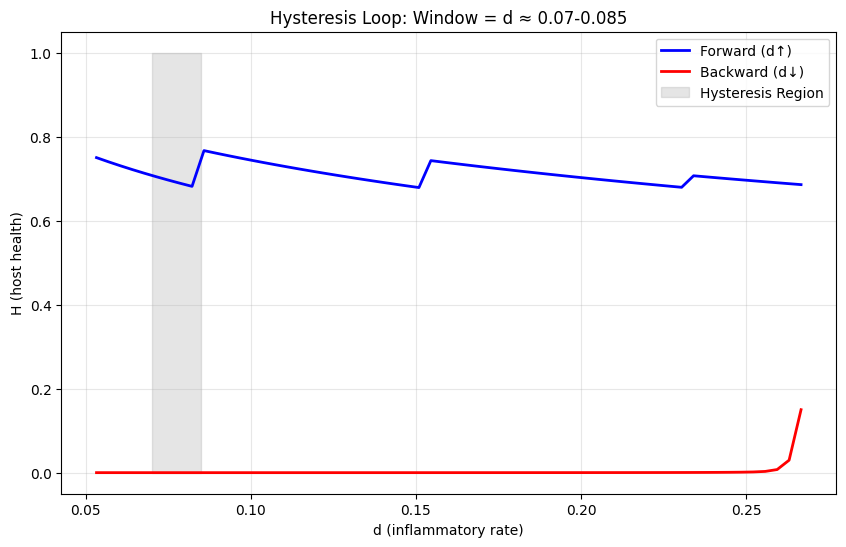

Hysteresis width: 0.015
Healthy state H: 0.767
Dysbiotic state H: 0.000


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your hysteresis data
forward = pd.read_csv("mw_analysis_v6_FINAL/sweep_forward_data.csv")
backward = pd.read_csv("mw_analysis_v6_FINAL/sweep_backward_data.csv")

# Plot enhanced hysteresis
plt.figure(figsize=(10, 6))
plt.plot(forward['d'], forward['H'], 'b-', label='Forward (d↑)', linewidth=2)
plt.plot(backward['d'], backward['H'], 'r-', label='Backward (d↓)', linewidth=2)
plt.fill_betweenx([0, 1], 0.07, 0.085, alpha=0.2, color='gray', label='Hysteresis Region')
plt.xlabel('d (inflammatory rate)')
plt.ylabel('H (host health)')
plt.title(f'Hysteresis Loop: Window = d ≈ 0.07-0.085')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate hysteresis metrics
hyst_width = 0.085 - 0.07
print(f"Hysteresis width: {hyst_width:.3f}")
print(f"Healthy state H: {forward['H'].max():.3f}")
print(f"Dysbiotic state H: {backward['H'].min():.3f}")